In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

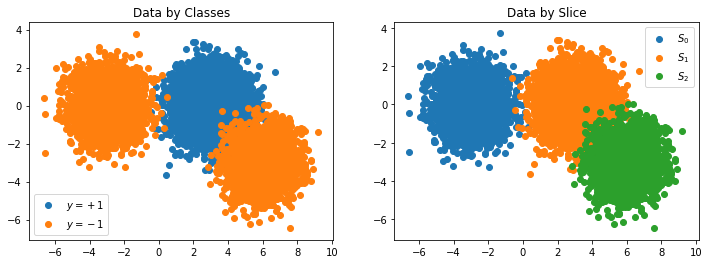

In [4]:
from synthetics_utils import generate_multi_mode_data, generate_label_matrix

# num simulated examples
N = 10000

# mus: [list of d-dim np.arrays] centers of the modes
mus = [
    np.array([-3, 0]), # Mode 1: Y = -1
    np.array([3, 0]), # Mode 2: Y = 1
    np.array([6, -3]) # Mode 3: Y = -1
]
# proportion of data in each mode
props = [0.25, 0.5, 0.25]

# class label of each mode
labels = [-1, 1, -1]

X, Y, C = generate_multi_mode_data(N, mus, props, labels)
S0_idx, S1_idx, S2_idx = np.where(C==0)[0], np.where(C==1)[0], np.where(C==2)[0]

# show data by class and slice
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Data by Classes')
plt.scatter(X[Y==1,0], X[Y==1,1], label="$y=+1$")
plt.scatter(X[Y==-1,0], X[Y==-1,1], label="$y=-1$")
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Data by Slice')
plt.scatter(X[C==0,0], X[C==0,1], label="$S_0$")
plt.scatter(X[C==1,0], X[C==1,1], label="$S_1$")
plt.scatter(X[C==2,0], X[C==2,1], label="$S_2$")
plt.legend()
plt.show()

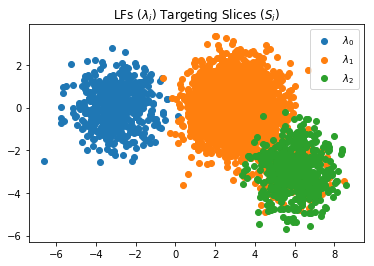

In [ ]:
# "simulated" accuracies and coverage of LFs
accs = np.array([0.75, 0.75, 0.75])
covs = np.array([0.9, 0.9, 0.9])

# overlap between primary "torso" LF and "head" LFs
overlap_portion = 0.05

# labeling function generation
L, overlap_idx = generate_label_matrix(N, accs, covs, Y, C, overlap_portion=overlap_portion)

# LFs targeting slices
plt.title('LFs ($\lambda_i$) Targeting Slices ($S_i$)')
plt.scatter(X[L[:,0]==1,0], X[L[:,0]==1,1], label="$\lambda_0$")
plt.scatter(X[L[:,1]==1,0], X[L[:,1]==1,1], label="$\lambda_1$")
plt.scatter(X[L[:,2]==1,0], X[L[:,2]==1,1], label="$\lambda_2$")
plt.legend()
plt.show()

In [ ]:
def eval_model(model, data, eval_dict):
    """Evaluates models according to indexes in 'eval_dict'
    Args:
        model: trained model to evaluate
        data: (X,Y) full test set to evaluate on 
        eval_dict: mapping eval slice {"slice_name":idx}
            where idx is list of indexes for corresponding slice
    Returns:
        results_dict: mapping {"slice_name": scores}
            includes "overall" accuracy by default
    """
    X, Y = data
    # conver to multiclass labels
    if -1 in Y:
        Y[Y==-1] = 2
    
    data = (torch.from_numpy(X.astype(np.float32)),
            torch.from_numpy(Y.astype(np.float32)))
    
    slice_scores = {}
    for slice_name, eval_idx in eval_dict.items():
        slice_scores[slice_name] = \
            model.score_on_slice(data, eval_idx, metric="accuracy", verbose=False)
    
    slice_scores["overall"] = model.score(data, metric="accuracy", verbose=False)
    return slice_scores

In [ ]:
from metal.contrib.slicing.online_dp import LinearModule, MLPModule, SliceDPModel
# from metal.contrib.slicing.online_dp_no_relu import SliceDPModel

def train_models(X, L, accs, verbose=False):
    """
    Trains baseline, oracle, and attention model
    Args:
        - X: features
        - L: LF matrix
        - accs: [list of floats] accuracies for LFs
    Returns:
        - model_[0,1,2]: trained baseline, oracle, and attention model
    """

    m = np.shape(L)[1] #num LFs
    d = X.shape[1] #num features
    X_train = torch.from_numpy(X.astype(np.float32))
    L_train = torch.from_numpy(L.astype(np.float32))

    #baseline model, no attention
    r=4
    baseline_model = SliceDPModel(LinearModule(d, r, bias=True), accs, r=r, rw=False, verbose=verbose)
    baseline_model.train_model((X_train, L_train), batch_size=1000, n_epochs=250, lr=0.1, print_every=50, validation_metric='f1', disable_prog_bar=True)

    #oracle, manual reweighting
    #TODO: currently hardcode weights so LF[-1] has double the weight
    weights = np.ones(m, dtype=np.float32)
    weights[-1] = 2.0
    r = 4
    manual_model = SliceDPModel(LinearModule(d, r, bias=True), accs, r=r, rw=False, L_weights=weights, verbose=verbose)
    manual_model.train_model((X_train, L_train), batch_size=1000, n_epochs=250, lr=0.1, print_every=50, validation_metric='f1', disable_prog_bar=True)

    #our model, with attention
    r = 2
    attention_model = SliceDPModel(LinearModule(d, r, bias=True), accs, r=r, rw=True, verbose=verbose)
    attention_model.train_model((X_train, L_train), batch_size=1000, n_epochs=250, lr=0.1, print_every=50, validation_metric='f1', disable_prog_bar=True)

    return baseline_model, manual_model, attention_model

In [ ]:
%%time
#train the models and score the models (I KNOW ITS UGLY)
baseline_model, manual_model, attention_model = train_models(X,L,accs,verbose=True)
eval_dict = {'overlap': overlap_idx, 'S0': S0_idx, 'S1': S1_idx, 'S2':S2_idx}
print('Baseline:', eval_model(baseline_model, (X,Y), eval_dict))
print('Manual:', eval_model(manual_model, (X,Y), eval_dict))
print('Attention:', eval_model(attention_model, (X,Y), eval_dict))

Slice Heads:
Input Network: Sequential(
  (0): Sequential(
    (0): LinearModule(
      (input_layer): Linear(in_features=2, out_features=4, bias=True)
    )
    (1): ReLU()
  )
)
L_head: Linear(in_features=4, out_features=3, bias=False)
Y_head: Linear(in_features=4, out_features=2, bias=False)
[E:0]	Train Loss: 0.011
[E:50]	Train Loss: 0.010
[E:100]	Train Loss: 0.010
[E:150]	Train Loss: 0.010
[E:200]	Train Loss: 0.010
[E:249]	Train Loss: 0.010
Finished Training
Slice Heads:
Input Network: Sequential(
  (0): Sequential(
    (0): LinearModule(
      (input_layer): Linear(in_features=2, out_features=4, bias=True)
    )
    (1): ReLU()
  )
)
L_head: Linear(in_features=4, out_features=3, bias=False)
Y_head: Linear(in_features=4, out_features=2, bias=False)
[E:0]	Train Loss: 0.014
[E:50]	Train Loss: 0.014
[E:100]	Train Loss: 0.014
[E:150]	Train Loss: 0.014
[E:200]	Train Loss: 0.014
[E:249]	Train Loss: 0.014
Finished Training
Slice Heads:
Input Network: Sequential(
  (0): Sequential(
    (0)

In [ ]:
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict

## Vary Overlap Proportion between head and torso LFs

In [ ]:
%%time

N = 10000
# mus: [list of d-dim np.arrays] centers of the modes
mus = [
    np.array([-3, 0]), # Mode 1: Y = -1
    np.array([3, 0]), # Mode 2: Y = 1
    np.array([6, -3]) # Mode 3: Y = -1
]
# proportion of data in each mode
props = [0.25, 0.5, 0.25]

# accuracy / coverage of LFs
accs = np.array([0.75, 0.75, 0.75])
covs = np.array([0.9, 0.9, 0.9])
m = np.shape(accs)[0]

# to collect scores for all models
baseline_scores, manual_scores, attention_scores = defaultdict(list), defaultdict(list), defaultdict(list)

#overlap portion
op_range = np.linspace(0, 1.0, 10)
# op_range = [0.0, 0.05, 0.1, 0.15, 0.2]

# num trials to re-run each simulation
num_trials = 25

for op in op_range:
    print (f"Overlap Proportion: {op}")
    for _ in tqdm(range(num_trials)):
        # generate data
        accs = np.array([0.75, 0.75, 0.75])
 
        X, Y, C = generate_multi_mode_data(N, mus, props, labels)
        L, overlap_idx = generate_label_matrix(N, accs, covs, Y, C, overlap_portion=op)

        # train the models
        baseline_model, manual_model, attention_model = train_models(X, L, accs)

        # score the models
        S0_idx, S1_idx, S2_idx = np.where(C==0)[0], np.where(C==1)[0], np.where(C==2)[0]
        eval_dict = {'overlap': overlap_idx, 'S0': S0_idx, 'S1': S1_idx, 'S2':S2_idx}
        baseline_scores[op].append(eval_model(baseline_model, (X,Y), eval_dict))
        manual_scores[op].append(eval_model(manual_model, (X,Y), eval_dict))
        attention_scores[op].append(eval_model(attention_model, (X,Y), eval_dict))

Overlap Proportion: 0.0


In [ ]:
slice_name = 'S2'
print ([np.var(np.array([s[slice_name] for s in baseline_scores[op]]))
                      for op in op_range])

print ([np.var(np.array([s[slice_name] for s in manual_scores[op]]))
                      for op in op_range])

print ([np.var(np.array([s[slice_name] for s in attention_scores[op]]))
                      for op in op_range])

In [ ]:
import json
import datetime

results = {
    'baseline': dict(baseline_scores),
    'manual': dict(manual_scores),
    'attention': dict(attention_scores)
}
date = datetime.datetime.today().strftime('%Y-%m-%d')
json.dump(results, open(f'op-extended-{date}.json', 'w'))

In [6]:
import json
results = json.load(open('op-extended-2019-01-02.json', 'r'))

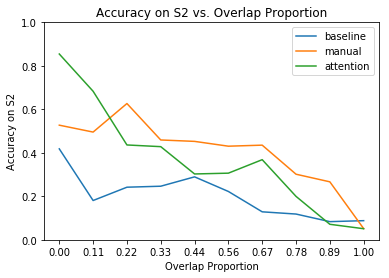

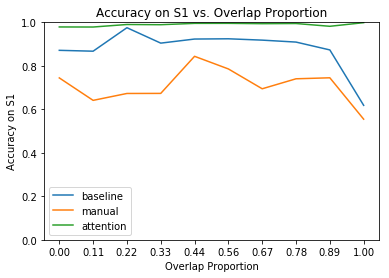

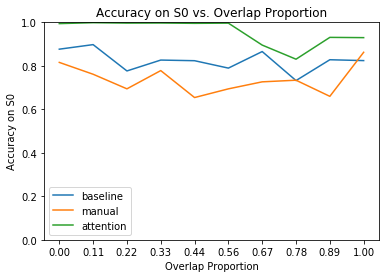

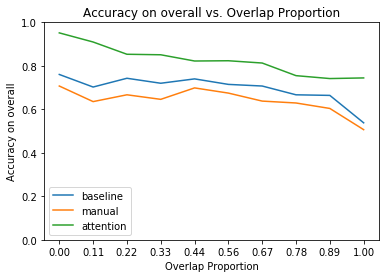

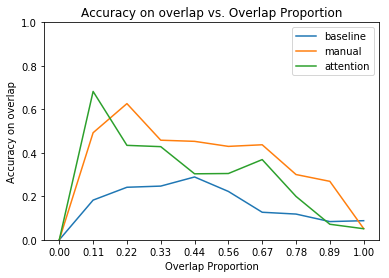

In [9]:
from synthetics_utils import plot_slice_scores
plot_slice_scores(results, 'S2', xlabel='Overlap Proportion')
plot_slice_scores(results, 'S1', xlabel='Overlap Proportion')
plot_slice_scores(results, 'S0', xlabel='Overlap Proportion')
plot_slice_scores(results, 'overall', xlabel='Overlap Proportion')
plot_slice_scores(results, 'overlap', xlabel='Overlap Proportion')